In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

In [67]:
import os
import numpy as np
import pandas as pd
import pyranges as pr
import scanpy as sc
import scipy
import seaborn as sns
import pickle
from itertools import chain
from matplotlib import pyplot as plt
import tqdm
import glob

In [4]:
data_path = '/s/project/QNA/scborzoi/submission_data/'

### Specify genome

In [5]:
gtf_file = f"{data_path}gencode.v32.annotation.gtf"
fasta_file = f"{data_path}genome_human.fa"
with open(f"{data_path}/gencode.v32.annotation.gtf.transcriptome", 'rb') as handle:
    transcriptome = pickle.load(handle)

In [6]:
gtf = pr.read_gtf(gtf_file, duplicate_attr = True)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [7]:
cell_type_index = pd.read_parquet(os.path.join(data_path,'borzoi_training_data/celltype_fixed.pq'))
cell_type_index['size'] = cell_type_index['cellindex'].apply(lambda x: len(x))

In [8]:
cell_type_index['celltype_name'] = cell_type_index['celltype'].copy()
cell_type_index['celltype'] = cell_type_index['celltype'].str.replace(' ', '_').replace(r"G/M_prog", "G+M_prog").replace("MK/E_prog", "MK+E_prog")
cell_type_index = cell_type_index.sort_values('celltype')

In [9]:
cell_type_index = cell_type_index.reset_index(drop=True)

In [10]:
context_length = 524288 
clip_soft=5

### Read in adata

In [11]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad')
)

In [12]:
ct_colors = dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))

### Read in predicted SNPs

In [13]:
snp_preds = pd.read_pickle(f"{data_path}/eQTL_preds/susie_snps_preds_fixed.pickle").iloc[:15900]

In [14]:
snp_preds_2 = pd.read_pickle(f"{data_path}/eQTL_preds/susie_snps_preds_fixed_16k.pickle")

In [15]:
snp_preds = pd.concat([snp_preds, snp_preds_2])

In [16]:
snp_preds = snp_preds.dropna()

In [17]:
snp_preds = snp_preds.rename({'gene_name' : 'Gene', 'variant_hg38' : 'snp_id'}, axis = 1)

In [18]:
filter_ = snp_preds.groupby(['snp_id', 'Gene']).size().index[(snp_preds.groupby(['snp_id', 'Gene']).size() ==12).values]

In [19]:
snp_preds = snp_preds.set_index(['snp_id', 'Gene']).loc[filter_].reset_index()

In [20]:
# signed difference
def celltype_difference(df):
    # pseudobulk
    df['pred'] = df.apply((lambda x: np.array([np.log2(x['pred'][cellindex].sum() + 1) for cellindex in cell_type_index.cellindex])), axis=1)
    ref = df.query("type == 'ref'")['pred'].item()

    #df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df = df.groupby('type').agg({'difference': 'mean',}) # mean over decoy

    #mean over cell_types
    return df

In [21]:
def all_difference(df):
    # pseudobulk
    df['pred'] = df.apply(lambda x: np.array(np.log2(x['pred'].sum() + 1) ), axis=1)
    df['pred_sum'] = df.apply(lambda x: np.array(x['pred'].sum() ), axis=1)
    ref = df.query("type == 'ref'")['pred'].item()

    #df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df = df.groupby('type').agg({'difference': 'mean',}) # mean over decoy

    #mean over cell_types
    return df

In [50]:
ct_differences = snp_preds.groupby(['snp_id', 'Gene']).apply(celltype_difference)

In [51]:
ct_differences = ct_differences['difference'].apply(lambda x: pd.Series(x, index=cell_type_index.celltype_name)).reset_index()

In [24]:
all_differences = snp_preds.groupby(['snp_id', 'Gene']).apply(all_difference)

In [25]:
all_differences = all_differences['difference'].apply(lambda x: pd.Series(x, index=['all'])).reset_index()

## Whole heatmap, filter for sign concoordant and mean expr > 0.05 (a,b)

In [52]:
sign_concordant_all = all_differences.query("type == 'eSNP'").set_index(['snp_id', 'Gene'])[['all', 'type']].melt(id_vars='type', ignore_index=False).reset_index().pivot(columns='type', values='value', index=['variable', 'snp_id', 'Gene']).join(snp_preds.set_index(['snp_id', 'Gene']).query("type=='eSNP'").drop('pred', axis=1), on=['snp_id', 'Gene'])

sign_concordant_all = sign_concordant_all[(np.sign(sign_concordant_all['beta_posterior'].values) == np.sign(sign_concordant_all['eSNP'].values))]
sign_concordant_all[['beta_posterior', 'eSNP']]
#sign_concordant = sns_df[(np.sign(sns_df['beta_posterior'].values) == np.sign(sns_df['eSNP'].values))]
ct_differences = ct_differences.set_index(['snp_id', 'Gene']).query('type == "eSNP"').loc[sign_concordant_all.index.droplevel(0)].reset_index()



means = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene']).iloc[:,2:].T.abs().mean(axis=0)  
variances = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene']).iloc[:,2:].T.var(axis=0) 
quantiles = variances.loc[means[means > 0.05].index].quantile([.15, .85]).values

In [53]:
ct_differences = ct_differences.set_index(['snp_id','Gene'])[means > 0.05].reset_index()
var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[
(variances > quantiles[1]) & (means > 0.05) ].index
non_var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[
(variances < quantiles[0]) & (means > 0.05) ].index

/scratch/tmp/hingerl/ipykernel_3269996/2252236172.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[
/scratch/tmp/hingerl/ipykernel_3269996/2252236172.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[


In [54]:
len(ct_differences)

370

In [55]:
ct_colors = pd.Series(adata.uns['l2_cell_type_colors'], 
                     index=adata.obs['l2_cell_type'].values.categories)

In [56]:
colors_equal = dict()
for lineage in adata.obs.l1_cell_type.unique():
    l2_cell_types = adata.obs.query("l1_cell_type == @lineage").l2_cell_type.unique().tolist()
    
    if " B" in l2_cell_types[0] or 'Early' in l2_cell_types[0] or 'Plasma' in l2_cell_types[0]:
        setter = '#023fa5'
    elif "T " in l2_cell_types[0] or 'NK' in l2_cell_types[0]:
        setter = '#c5dbc6'
    elif "Mono" in l2_cell_types[0]:
        setter = '#8e063b'
    elif 'Erythro' in l2_cell_types[0]:
        setter = '#8595e1'
    else:
        setter = '#808080'
    for l2 in l2_cell_types:
        colors_equal[l2] = setter


In [57]:
colors_equal['HSC'] = '#e4aeb8'
colors_equal['G/M prog'] = '#e4aeb8'
colors_equal['MK/E prog'] = '#e4aeb8'
colors_equal['ILC'] = '#c5dbc6'


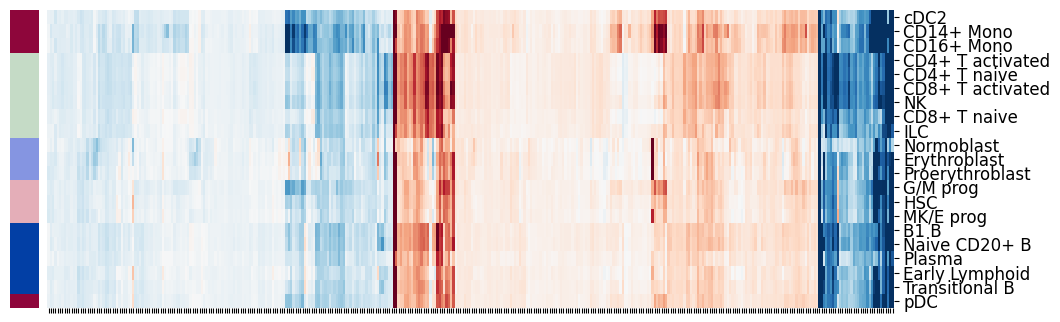

In [58]:
clustergrid = sns.clustermap(ct_differences.set_index(['snp_id','Gene']).reset_index(0).iloc[:,2:].T, 
            robust=True, 
            metric = "seuclidean", 
            method = 'ward', 
            yticklabels = 1,
            xticklabels = 1,  
            figsize=(12,6), 
            row_colors= [colors_equal[x] for x in ct_differences.set_index(['snp_id','Gene']).reset_index(0).iloc[:,2:].columns.tolist()],
            cmap = 'RdBu_r', 
            center=0, 
            row_cluster=True,
            col_cluster=True,
            vmin = -1, vmax = 1,
            dendrogram_ratio=(0.1, .3))
clustergrid.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
clustergrid.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
clustergrid.ax_cbar.set_visible(False)
labels = clustergrid.ax_heatmap.get_xticklabels()
for lbl in labels:
    lbl.set_visible(False)
    continue
    # print (lbl)
    lbl.set_fontsize(6) 
    if lbl.get_text() in highlight_genes:# var_genes.get_level_values(1).values:
        lbl.set_color('red')
    elif lbl.get_text() in var_genes.get_level_values(1).values:
        lbl.set_color('black')
    else:
        lbl.set_visible(False)
    
    lbl.set_style('italic')
clustergrid.ax_heatmap.set_xlabel("")
clustergrid.ax_heatmap.set_ylabel("")
row_order = clustergrid.dendrogram_row.reordered_ind
# plt.savefig('../figures/figures/Figure4/heatmap_all_concordant_colored_by_gwas.svg', dpi=300, bbox_inches ='tight')

In [64]:
gwas = pd.read_table(f"{data_path}gwas_catalog.tsv")

/scratch/tmp/hingerl/ipykernel_3269996/972965925.py:1: DtypeWarning: Columns (9,11,12,13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  gwas = pd.read_table(f"{data_path}gwas_catalog.tsv")


In [68]:
rs_id_match = []
for path in tqdm.tqdm(glob.glob("../neurips/GTEx_Analysis_v8_eQTL/*.egenes.txt")):
    rs_id_match.append(pd.read_table(path)[['variant_id', 'rs_id_dbSNP151_GRCh38p7']])
rs_id_match = pd.concat(rs_id_match)

100%|██████████| 49/49 [00:04<00:00, 10.31it/s]


In [71]:
rs_id_match['snp_id'] = rs_id_match['variant_id'].str.replace("_b38", "")
rs_id_merge = ct_differences.merge(rs_id_match[['snp_id', 'rs_id_dbSNP151_GRCh38p7']].drop_duplicates(), on = 'snp_id', how = 'left')

In [74]:
row_colors = [colors_equal[x] for x in ct_differences.iloc[:,3:].iloc[:,row_order].columns.tolist()]

Text(644.0277777777778, 0.5, '')

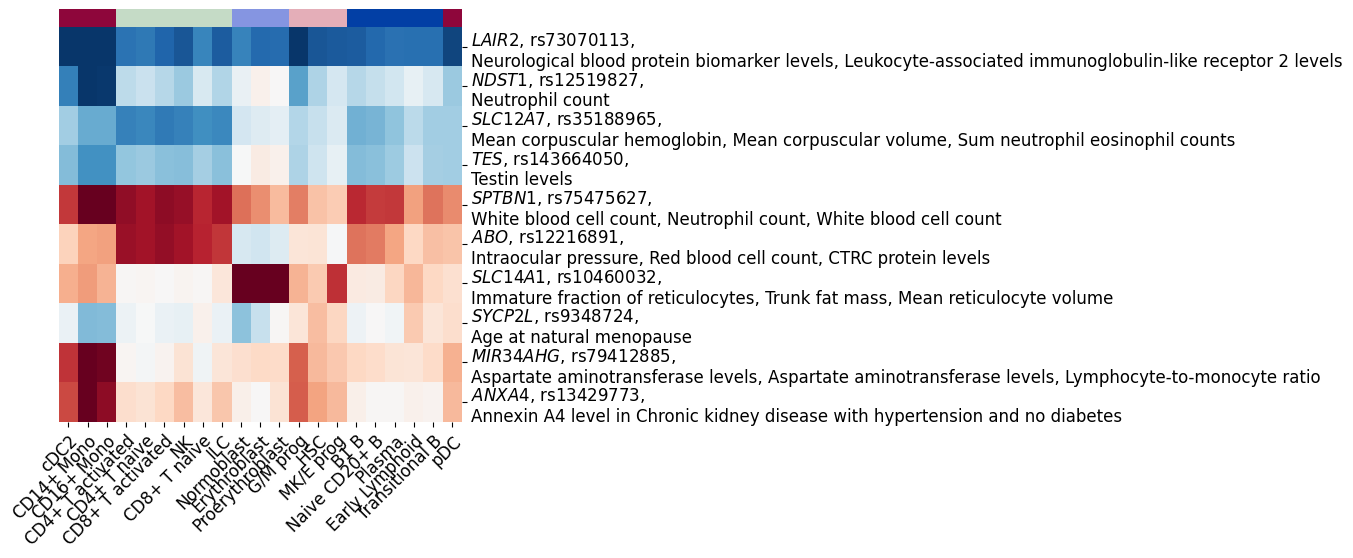

In [75]:
gwas_mapped = rs_id_merge.set_index(['snp_id', 'Gene']).loc[var_genes].reset_index().merge(gwas[['SNPS', 'DISEASE/TRAIT', 'MAPPED_GENE']], left_on= ['rs_id_dbSNP151_GRCh38p7', 'Gene'], right_on=['SNPS','MAPPED_GENE'])[['Gene', 'rs_id_dbSNP151_GRCh38p7', 'DISEASE/TRAIT', 'MAPPED_GENE']]
highlight_genes = gwas_mapped.Gene.unique()

gwas_mapped =gwas_mapped.groupby(['Gene', 'rs_id_dbSNP151_GRCh38p7']).agg(list)

import math
clustergrid = sns.clustermap(ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene']).loc[var_genes].reset_index(0).loc[highlight_genes].iloc[:,2:].iloc[:,row_order], 
               robust=True, 
               metric = "seuclidean", 
               method = 'ward', 
               yticklabels = 1,
               xticklabels = 1, 
               col_colors=row_colors,
               figsize=(6,8), 
               cmap = 'RdBu_r', col_cluster = False,
               center=0, 
               dendrogram_ratio=(0.1, .3))
clustergrid.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
clustergrid.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
clustergrid.ax_cbar.set_visible(False)
labels = clustergrid.ax_heatmap.get_yticklabels()
labels_new = []
rs_ids = []
for lbl in labels:
    lbl_text = lbl.get_text()
    rs_id = rs_id_merge.query("Gene == @lbl_text")['rs_id_dbSNP151_GRCh38p7'].iloc[0]
    if "SLC12A7" in lbl_text:
        terms = ", ".join(gwas_mapped.loc[lbl_text].iloc[0]['DISEASE/TRAIT'][3:3+3])
    else:
        terms = ", ".join(gwas_mapped.loc[lbl_text].iloc[0]['DISEASE/TRAIT'][-3:])
    if "Annexin" in terms:
        terms = terms.replace("(17164_15)", "")
    if type(rs_id) == float:
        rs_id = manual_merge[lbl_text]
        # print (lbl_text)
    rs_ids.append(rs_id)
    labels_new.append("$\it{" + lbl_text + "}$"+ f", {rs_id},\n{terms}")
clustergrid.ax_heatmap.set_yticklabels(labels_new)
labels = clustergrid.ax_heatmap.get_yticklabels()
clustergrid.ax_heatmap.set_yticklabels(clustergrid.ax_heatmap.get_yticklabels())
clustergrid.ax_heatmap.set_xticklabels(clustergrid.ax_heatmap.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
for lbl in labels:
    pass
    # lbl.set_style('italic')
    #lbl.set_ha("right")
    #lbl.set_rotation(20)

clustergrid.ax_heatmap.set_xlabel("")
clustergrid.ax_heatmap.set_ylabel("")
# plt.savefig('../figures/figures/Figure4/GWAS_only.png', dpi=300, bbox_inches ='tight')

## Profiles (c)

In [94]:
genes_to_test = pd.concat([ct_differences.query('type == "eSNP"').set_index(["snp_id", "Gene"]).loc[non_var_genes].reset_index(),
                           ct_differences.query('type == "eSNP"').set_index(["snp_id", "Gene"]).loc[var_genes].reset_index()]
                         )

In [95]:
genes_to_test = genes_to_test[genes_to_test.Gene.isin( ["DCTN5", "TES"])] #

In [96]:
genes_to_test

celltype_name,snp_id,Gene,type,B1 B,CD14+ Mono,CD16+ Mono,CD4+ T activated,CD4+ T naive,CD8+ T activated,CD8+ T naive,...,ILC,MK/E prog,NK,Naive CD20+ B,Normoblast,Plasma,Proerythroblast,Transitional B,cDC2,pDC
12,chr16_23642022_C_T,DCTN5,eSNP,0.083043,0.089361,0.088050,0.078491,0.079047,0.078717,0.078400,...,0.075344,0.065959,0.078513,0.083420,0.054320,0.073566,0.056572,0.079107,0.082273,0.082659
51,chr7_116211123_G_A,TES,eSNP,-0.466523,-0.649831,-0.650397,-0.425851,-0.399438,-0.443410,-0.367176,...,-0.449190,-0.091629,-0.458902,-0.447667,-0.005217,-0.389551,0.049210,-0.364435,-0.464992,-0.373669


In [66]:
from enformer_pytorch.data import GenomeIntervalDataset, str_to_one_hot
from trackplot.plot import Plot

In [88]:
%matplotlib inline

['DCTN5', 'chr16_23642022_C_T']
C T
244697


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
2024-08-22 14:43:50.859 | INFO     | trackplot.plot:__init__:209 - Create trackplot version: 0.4.0
2024-08-22 14:43:50.861 | INFO     | trackplot.plot:set_region:265 - set region to chr16:23631852-23687052:+


DCTN5


2024-08-22 14:44:03.774 | INFO     | trackplot.plot:set_annotation:434 - set annotation file to /data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf
2024-08-22 14:44:03.776 | INFO     | trackplot.file.Annotation:index_gtf:329 - Create index for /data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf
2024-08-22 14:44:03.777 | DEBUG    | trackplot.file.Annotation:index_gtf:338 - Guess gtf needs to be sorted: Could not open file '/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf.gz': No such file or directory
[E::hts_open_format] Failed to open file "/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf.gz" : No such file or directory
2024-08-22 14:44:04.062 | INFO     | trackplot.plot:plot:1093 - load annotation
2024-08-22 14:44:04.075 | INFO     | trackplot.plot:plot:1107 - load data of 0 plots
2024-08-22 14:44:04.076 | DEBUG    | trackpl

1.0
['TES', 'chr7_116211123_G_A']
G A
238622


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
2024-08-22 14:44:06.445 | INFO     | trackplot.plot:__init__:209 - Create trackplot version: 0.4.0
2024-08-22 14:44:06.446 | INFO     | trackplot.plot:set_region:265 - set region to chr7:116200916-116268340:+


TES


2024-08-22 14:44:19.417 | INFO     | trackplot.plot:set_annotation:434 - set annotation file to /data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf
2024-08-22 14:44:19.418 | INFO     | trackplot.file.Annotation:index_gtf:329 - Create index for /data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf
2024-08-22 14:44:19.419 | DEBUG    | trackplot.file.Annotation:index_gtf:338 - Guess gtf needs to be sorted: Could not open file '/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf.gz': No such file or directory
[E::hts_open_format] Failed to open file "/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.gtf.gz" : No such file or directory
2024-08-22 14:44:19.710 | INFO     | trackplot.plot:plot:1093 - load annotation
2024-08-22 14:44:19.724 | INFO     | trackplot.plot:plot:1107 - load data of 0 plots
2024-08-22 14:44:19.725 | DEBUG    | trackpl

1.0


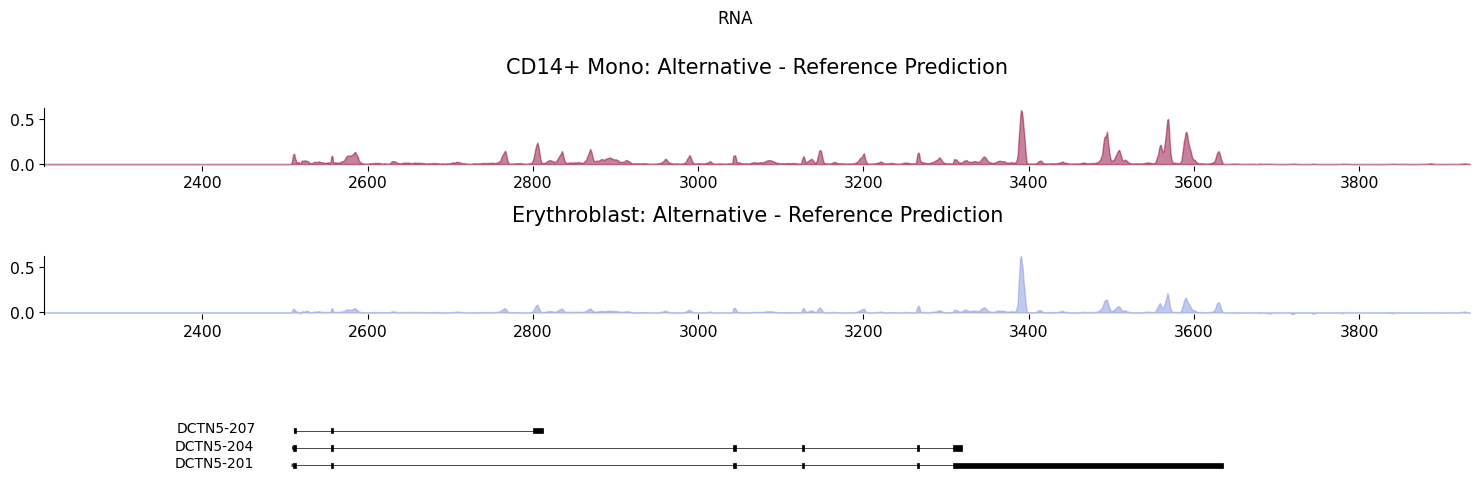

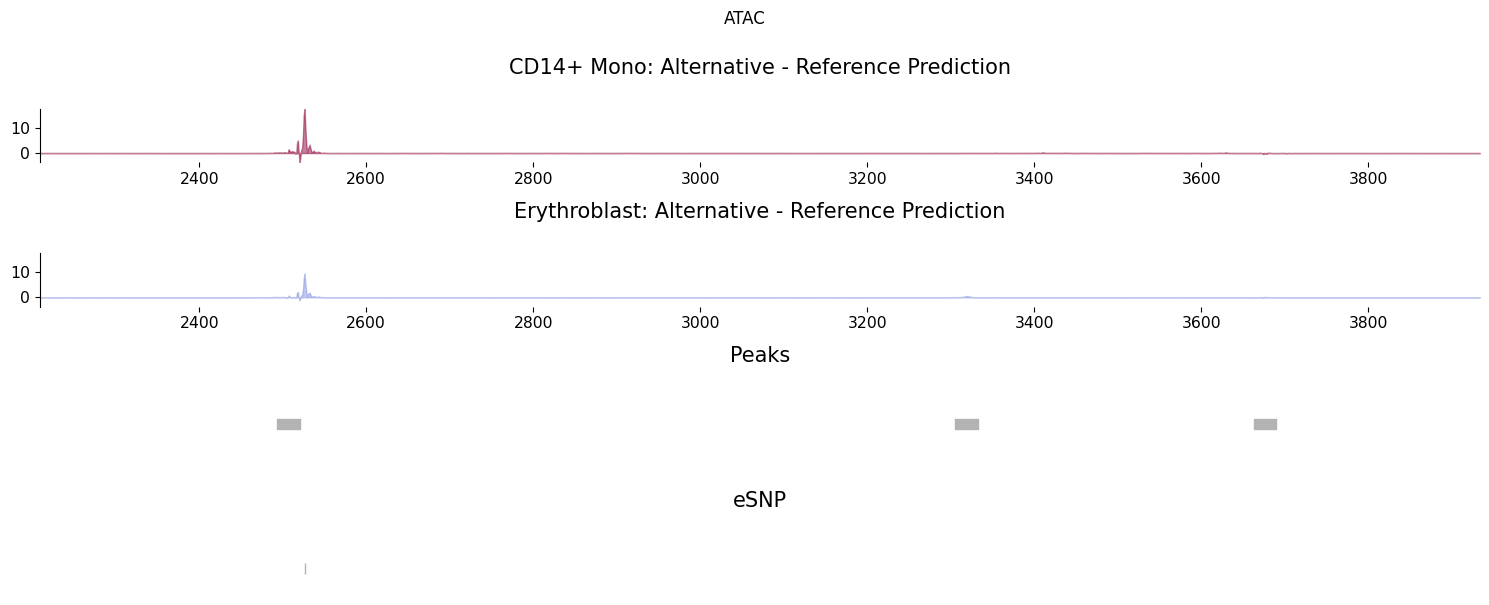

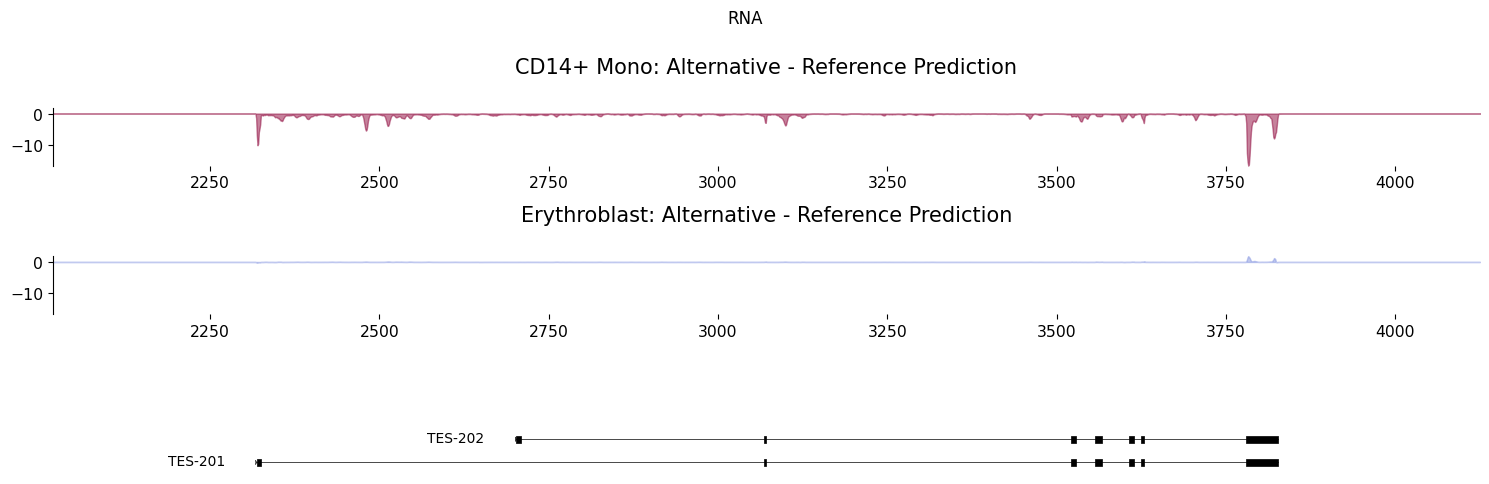

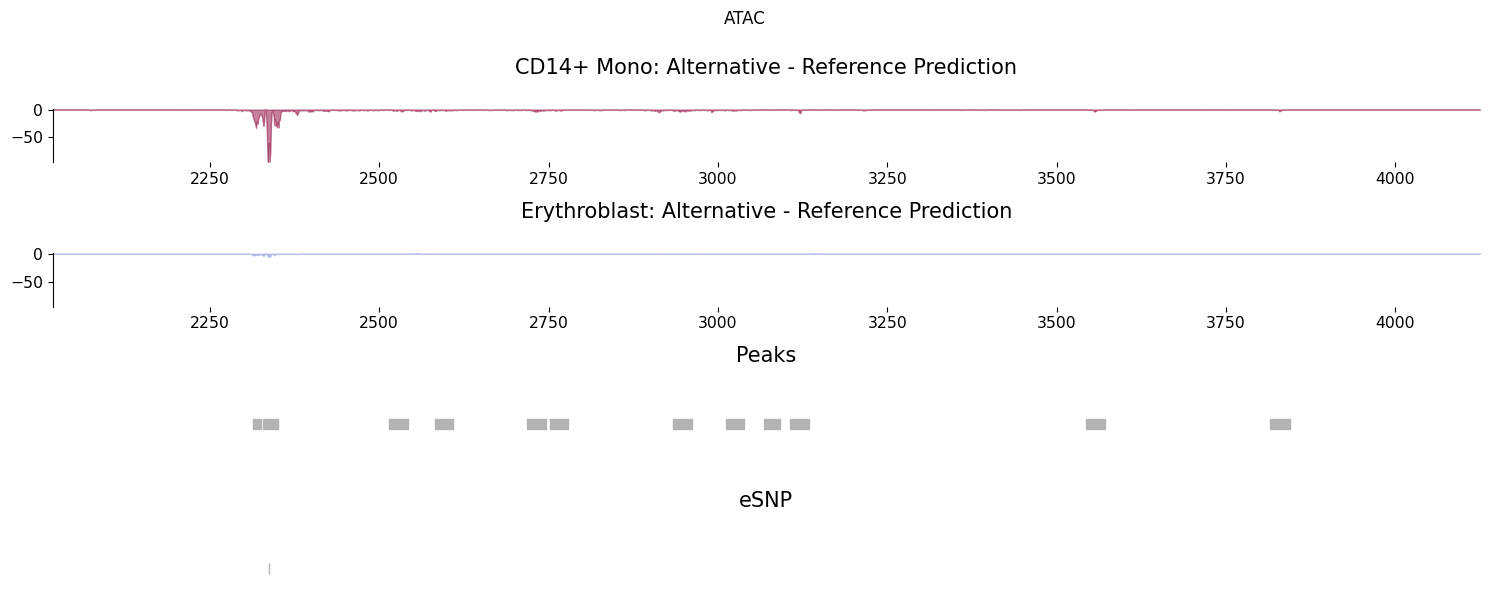

In [92]:

for i_gene, (_, row) in enumerate(genes_to_test.iterrows()):

    print([row['Gene'], row['snp_id']])

    gene, rsid = row['Gene'], row['snp_id']
    row_to_process = snp_preds.query("type == 'ref'").query('(snp_id == @rsid) & (Gene == @gene)')
    hg38_pos = int(row_to_process['Start'].item())
    ref = row_to_process['nuc'].item()
    alt = snp_preds.query("type == 'eSNP'").query('(snp_id == @rsid) & (Gene == @gene)')['nuc'].item()
    print(ref, alt)
    
    genes = pd.Series([
        gene
    ])
    
    filter_val = lambda df: df.filter(pl.col('column_4').is_in(genes))#
    #filter_val = lambda df: df.filter(True)
    val_ds = GenomeIntervalDataset(
        bed_file = os.path.join(data_path,'borzoi_training_data', 'train_val_test_gene_sequences.csv'),
        fasta_file = fasta_file,
        filter_df_fn = filter_val,
        return_seq_indices = False,
        shift_augs = (0,0),
        rc_aug = False,
        return_augs = True,
        context_length = context_length,
        chr_bed_to_fasta_map = {}
    )
    
    val_dataset = onTheFlyExonMultiomePseudobulkDataset(
        cell_types = ['CD14+_Mono', 'Erythroblast'],
        ds = val_ds,
        base_path = base_path,
        clip_soft = 5,
    )
    
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 0)
    csb, val_loader = accelerator.prepare(csb, val_loader)
    
    
    all_outputs_rna, all_outputs_atac, all_outputs_rna_alt, all_outputs_atac_alt, all_targets_rna, all_targets_atac = [], [], [], [],[], []
    
    genotype_map = {0:"alt",  2:"ref"}
    
    diff_target, diff_predicted, snps_tested = [], [], []
    csb.eval()
    
    
    # Test how our model predicts SNP effects
    
    ### Get outputs for all cells for that region
    
    alt = str_to_one_hot(alt).cuda() 
    ref = str_to_one_hot(ref).cuda()

    start = val_ds.df['column_2'].item() - ((context_length - (6144*32))//2)
    
    snp_idx = hg38_pos - start - 1
    print(snp_idx)
    # iterate over all val gene sequences
    for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):   
        gene_slice, strand = get_gene_slice_and_strand(
            transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
        )
        bs = x[0].shape[0]
        seqs = x[0].cuda().permute(0,2,1)
        seqs_alt = seqs.clone()
        assert torch.allclose(seqs_alt[:, :, snp_idx], ref)
        seqs_alt[:, :, snp_idx] = alt 
        assert torch.allclose(seqs_alt[:, :, snp_idx], alt)
        stacked_outputs_rna, stacked_outputs_atac, stacked_counts_outputs_rna = [], [], []
    
        # go over embeddings for all cells of a cell type, sum the unsquashed predictions
        outputs = get_pseudobulk_profile_pred(csb, seqs, cell_emb_conv_weights_and_biases, predict, clip_soft=clip_soft, model_type='multiome', num_neighbors=1)
        all_outputs_rna.append(outputs[0].detach().clone().cpu() if strand == '+' else outputs[1].detach().clone().cpu()) 
        all_outputs_atac.append(outputs[2].detach().clone().cpu()) 
    
        # go over embeddings for all cells of a cell type, sum the unsquashed predictions
        outputs = get_pseudobulk_profile_pred(csb, seqs_alt, cell_emb_conv_weights_and_biases, predict, clip_soft=clip_soft, model_type='multiome', num_neighbors=1)
        all_outputs_rna_alt.append(outputs[0].detach().clone().cpu() if strand == '+' else outputs[1].detach().clone().cpu()) 
        all_outputs_atac_alt.append(outputs[2].detach().clone().cpu()) 
        
        targets = x[2].float().cuda()
        # get RNA:
        targets_rna = targets[:,:,torch.tensor([1,1,0]).repeat(targets.shape[2]//3).bool()]
        targets_rna = targets_rna.float().detach()
    
        num_pos = targets_rna.shape[-1]
        # get ATAC:
        targets_atac = targets[:,:,torch.tensor([0,0,1]).repeat(targets.shape[2]//3).bool()]
        targets_atac = targets_atac.float().detach()
        if strand == '+':
            all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, :num_pos:2], clip_soft=5).detach().clone().cpu().T)
        elif strand == '-':
            all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, 1:num_pos:2], clip_soft=5).detach().clone().cpu().T)
    
        all_targets_atac.append(targets_atac[0].detach().clone().cpu().T)


    all_outputs_rna, all_outputs_atac, all_outputs_rna_alt, all_outputs_atac_alt = torch.stack(all_outputs_rna, axis=0).clone().numpy(force=True), torch.stack(all_outputs_atac, axis=0).clone().numpy(force=True) , torch.stack(all_outputs_rna_alt, axis=0).clone().numpy(force=True), torch.stack(all_outputs_atac_alt, axis=0).clone().numpy(force=True)
    all_targets_rna, all_targets_atac = torch.stack(all_targets_rna, axis=0).clone().numpy(force=True), torch.stack(all_targets_atac, axis=0).clone().numpy(force=True)

    # all_outputs_atac_alt = all_outputs_atac_alt * 20 #np.abs(all_outputs_atac_alt * 20 - all_outputs_atac)
    all_outputs_atac_alt = all_outputs_atac_alt  - all_outputs_atac
    
    # all_outputs_rna_alt = all_outputs_rna_alt #
    all_outputs_rna_alt = all_outputs_rna_alt - all_outputs_rna
    
    size=15
    params = {'legend.fontsize': 'large',
              'figure.figsize': (10,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size*0.75,
              'ytick.labelsize': size*0.75,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    
    print(val_dataset.genome_ds.df[i, 'column_4'])
    gene = val_dataset.genome_ds.df[i, 'column_4']
    
    # Get gene range
    gene_slice, strand = get_gene_slice_and_strand(
            transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
        )
    
    
    # Get peaks
    region = val_dataset.genome_ds.df[i].to_pandas()
    region.columns = ['Chromosome', 'Start', 'End', 'Gene Name', 'Strand']
    region = pr.PyRanges(region)
    region_peaks = atac_peaks.overlap(region).df
    region_peaks = region_to_bin(region_peaks.Start, region_peaks.End, val_dataset.genome_ds.df[i, 'column_2'], 6144*32, 32 )
    
    # Get snp
    region_snp = region_to_bin(row_to_process['Start'], row_to_process['Start']+1, val_dataset.genome_ds.df[i, 'column_2'], 6144*32, 32 )
    
    # Get color map
    color_map = dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))

    
    loffset=300
    roffset=300
    
    interval = (gene_slice.min()-loffset, gene_slice.max()+roffset)
    
    #ylim atac
    ylim_atac_out_alt = (all_outputs_atac_alt[:, :, interval[0]: interval[1]].min(), all_outputs_atac_alt[:, :, interval[0]: interval[1]].max())
    
    #ylim rna
    ylim_rna_out_alt = (all_outputs_rna_alt[:, :, interval[0]: interval[1]].min(), all_outputs_rna_alt[:, :, interval[0]: interval[1]].max())
   
    tracks_outputs_rna_alt = []
    tracks_outputs_atac_alt = []
    for idx, celltype in enumerate(['CD14+ Mono', 'Erythroblast']):
        cell_type = pd.Series([celltype])

        tracks_outputs_rna_alt.extend( list(
            zip(
                cell_type + ': Alternative - Reference Prediction', 
                all_outputs_rna_alt[0, [idx]]  ,
                np.repeat('coverage', 1),
                [ylim_rna_out_alt]
            )))
        
        tracks_outputs_atac_alt.extend(list(zip(
            cell_type + ': Alternative - Reference Prediction', 
            all_outputs_atac_alt[0, [idx]], 
            np.repeat('coverage', 1),
            [ylim_atac_out_alt]
        )))
        
    plot = Plot()
    plot.set_region( region.df["Chromosome"].item(), start= (region.df['Start'] + interval[0] * 32).item(), end= (region.df['Start'] + interval[1] * 32).item(), strand =strand)
    plot.set_annotation(
        gtf_file,                                             # path to gtf file
        add_domain=False,                                                                # whether add domain information into annotation track
        show_gene=False,                                                                 # show gene id
        transcripts = sorted(gtf.df[gtf.df.gene_name.isin([gene]) & (gtf.df.Feature == 'transcript') &(gtf.df.tag.str.contains('CCDS'))]['transcript_name'].values.tolist()),
        #color="pink",                                                                   # the color of exons
    )

    # resort to RNa, ATAC
    tracks_rna = tracks_outputs_rna_alt #
    tracks_atac = tracks_outputs_atac_alt
    tracks =  tracks_rna  
    rna = plot_tracks(
        tracks=tracks_rna, 
        interval=interval, 
        color_map=color_map, 
        fig_title="RNA",
        height=1.5,
        #save_name="EIFA1_RNA.svg",
        annotation_plot = plot,
        annotation_scale=1.2
    )
    rna[0].savefig(f'../figures/figures/Figure4/{gene}_RNA.png', bbox_inches='tight', dpi=300)
    
    tracks = tracks_atac + [('Peaks', region_peaks, 'bed', None)] + [('eSNP', region_snp, 'bed', None)]
    atac = plot_tracks(
        tracks=tracks, 
        interval=interval, 
        color_map=color_map, 
        fig_title="ATAC",
        height=1.5,
        #save_name="EIFA1_ATAC.svg",
)
    atac[0].savefig(f'../figures/figures/Figure4/{gene}_ATAC.png', bbox_inches='tight', dpi=300)

## Plot prediction on UMAP (d,e)

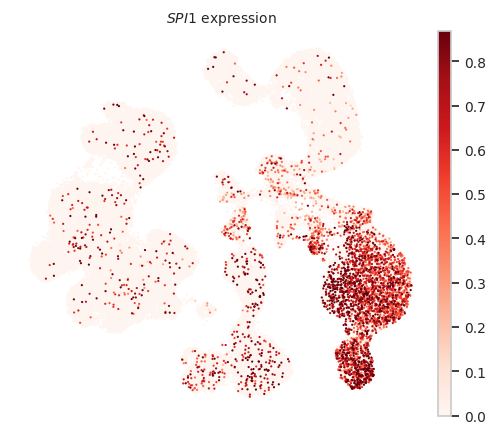

In [935]:
fig, ax = plt.subplots(figsize=(6,5))
sc.pl.umap(adata, color = f'SPI1', frameon = False, cmap = 'Reds', show = False, vmax = 'p99',  ax = ax, s = 10)
ax.set_title("$\it{SPI1}$ expression")#, font_size = 12)
fig.savefig("../figures/figures/Figure4/SPI1_expression.png", dpi=300, bbox_inches ='tight')

In [444]:
adata.obs['TES effect'] = (np.log2(snp_preds.query('Gene == "TES" and type == "eSNP"').iloc[0]['pred']) - np.log2(snp_preds.query('Gene == "TES" and type == "ref"').iloc[0]['pred']) )#.shape
#adata.obs['TES effect'] = 

<Axes: title={'center': 'TES effect'}, xlabel='UMAP1', ylabel='UMAP2'>

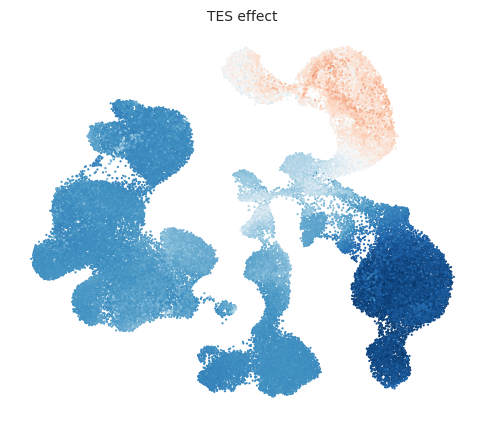

In [486]:
fig, ax = plt.subplots(figsize=(6,5))
sc.pl.umap(adata, color = 'TES effect', vcenter = 0,  cmap = 'RdBu_r', frameon = False, show = False, ax = ax, vmax = - np.quantile(adata.obs['TES effect'],0.01), vmin = np.quantile(adata.obs['TES effect'],0.01), colorbar_loc = None, s = 10)

In [487]:
ax.set_title("Variant effect on $\it{TES}$ expression")#, font_size = 12)
fig.savefig("../figures/figures/Figure4/TES_effect.png", dpi=300, bbox_inches ='tight')